# Flocking

참조 : <a href="http://www.red3d.com/cwr/boids/" target="_blank">http://www.red3d.com/cwr/boids/</a>

flock model은 새들이 3개의 단순한 규칙에 따라 행동 할 때 무리짓기 행동(flocking behavior)이 창발하는 것을 설명한다.

규칙

* 1) Separation : 다른 새들과 충돌을 피하면서 최소거리를 유지한다. (분산)
* 2) Cohesion   : 이웃한 새들의 평균 위치를 향해 날아 간다.(응집)
* 3) Alignment  : 이웃한 새들의 평균 방향으로 날아 간다. (정렬)

 소스 : <a href="https://github.com/mrchaos/julia_agents_examples" target="_blank">https://github.com/mrchaos/julia_agents_examples</a>
 
 ## 동작 환경
- Julia   : v1.7.2
- Agents  : v5.5.0
- InteractiveDynamics : v0.21.11
- GLMakie : v0.6.13
- CairoMakie : v0.8.13



- GLMakie를 사용하고 싶은 경우 설정에 대해서는 <a href="https://julialang.kr/?p=3684" target="_blank">https://julialang.kr/?p=3684</a> 를 참조

In [1]:
using Agents
using LinearAlgebra
using Random

### Define the core structure

* The fields `id` and `pos`, which are required for agents on [`ContinuousSpace`](@ref),are part of the struct. 
* The field `vel`, which is also added by using [`ContinuousAgent`](@ref) is required for using [`move_agent!`](@ref) in `ContinuousSpace` with a time-stepping method.
* `speed` defines how far the bird travels in the direction defined by `vel` per `step`.
* `seperation` defines the minimum distance a bird must maintain from its neighbors.
* `visual_distance` refers to the distance a bird can see and defines a radius of neighboring birds.
* The contribution of each rule defined above recieves an importance weight: 
* `cohere_factor` is the importance of maintaining the average position of neighbors,
* `match_factor` is the importance of matching the average trajectory of neighboring birds, and 
* `separate_factor` is the importance of maining the minimum distance from neighboring birds.

In [2]:
@agent Bird ContinuousAgent{2} begin
    speed::Float64
    cohere_factor::Float64
    separation::Float64
    separate_factor::Float64
    match_factor::Float64
    visual_distance::Float64
end

In [3]:
fieldnames(Bird)

(:id, :pos, :vel, :speed, :cohere_factor, :separation, :separate_factor, :match_factor, :visual_distance)

### Initialize Model

In [4]:
fieldnames(ABM)

(:agents, :space, :scheduler, :properties, :rng, :maxid)

In [5]:
function initialize_model(
        n_birds = 100,  # bird 수
        speed = 1.0,# 1 step당 속력 (방향은 vel에 정의된곳)
        cohere_factor = 0.25, # 이웃 새들의 평균 위치를 유지하는 중요성
        separation = 4.0, # 이웃 새들과 떨어져 있어야 하는 최소 거리
        separate_factor = 0.25, # 이웃 새들과의 최소거리를 유지하는 중요성
        match_factor = 0.01, #  이웃 새들의 평균 궤적 일치의 중요성
        visual_distance = 5.0, # 새가 볼 수 있는 거리를 나타내며 이웃 새의 반경을 정의
        extent = (100,100),
    )
    
    # ContinuousSpace(extent;spacing = minimum(extent)/20.0,update_vel! = no_vel_update,periodic = true)
    # continuous space 에서 periodic=true로 설정해야 move_agent!시 문제가 발생하지 않음
    space2d = ContinuousSpace(extent;spacing= visual_distance/1.5)
    
    # AgentBasedModel(Bird,space::S = nothing; scheduler::F = Schedulers.fastest, 
    #    properties::P = nothing, rng::R = Random.default_rng(), warn = true)
    model = ABM(Bird, space2d; scheduler = Schedulers.Randomly())
    
    for _ in 1:n_birds
        vel = Tuple(rand(model.rng, 2)*2 .- 1) #  -1 < vel < 1
        add_agent!(model,
            vel,
            speed,
            cohere_factor,
            separation,
            separate_factor,
            match_factor,
            visual_distance,            
        )
    end
    return model
end

initialize_model (generic function with 9 methods)

In [6]:
model = initialize_model()

AgentBasedModel with 100 agents of type Bird
 space: periodic continuous space with (100.0, 100.0) extent and spacing=3.3333333333333335
 scheduler: Agents.Schedulers.Randomly

In [7]:
fieldnames(typeof(model[1]))

(:id, :pos, :vel, :speed, :cohere_factor, :separation, :separate_factor, :match_factor, :visual_distance)

In [8]:
model[1]

Bird(1, (23.76015469908478, 5.463270390867869), (-0.4737905002561029, -0.8702897109684382), 1.0, 0.25, 4.0, 0.25, 0.01, 5.0)

In [9]:
model.agents[1]

Bird(1, (23.76015469908478, 5.463270390867869), (-0.4737905002561029, -0.8702897109684382), 1.0, 0.25, 4.0, 0.25, 0.01, 5.0)

### Defining the agent_step!
* `agent_step!` is the primary function called for each step and computes velocity according to the three rules defined above.

In [10]:
function agent_step!(bird, model)
    ## 새의 가시거리(visual distance)에 있는 이웃 새들의 id 획득
    neighbor_ids = nearby_ids(bird, model, bird.visual_distance)
    N = 0 # 이웃한 새들의 수
    match = separate = cohere = (0.0, 0.0)
    
    # 이웃한 새들에 기반한 행위 속성(behaiviour properties) 계산
    for id in neighbor_ids
        N += 1
        # model[id]는 model.agents[1] 과 동일하며 Bird를 돌려 준다.
        neighbor = model.agents[id].pos
        # 이웃새를 향한 위치 vector , 현재 선택된 새를 기준으로 다른 새들의 상대적 위치 vector
        heading = neighbor .- bird.pos
        
        ## `cohere` : 이웃한 새들의 평균 위치를 계산 : 규치2를 위한 계산
        cohere = cohere .+ heading # 위치벡터 합 계산
        
        # 규칙 1
        # 이웃 새와 떨어져 있어야할 최소 거리보다 작은 경우 이웃 새로 부터 멀어 진다. 
        if euclidean_distance(bird.pos, neighbor, model) < bird.separation
            # 이웃한 새를 향한 반대 방향으로 상대적 위치 만큼 멀어 진다.
            # 떨어지는 거리의 합산 계산
            separate = separate .- heading
        end
        ## `match` : 이웃한 새들의 평균 궤적(average trajectory)을 계산
        # 이웃한 새들의 속도를 합산 
        # ※ 속도 : 속력과 방량이 있음
        match = match .+ model.agents[id].vel
    end
    #  최소한 이웃한 새가 1마리는 있어야 함, 아래 계산상 N이 0이 되면 안됨
    N = max(N,1)
    
    ## 모델 입력값과 이웃새들의 수에 기반한 결과들을 normalize
    ## 가중치의 역할 : 새의 속도를 계산할 때 규칙1,2,3의 중요도에 대한 가중치
    ##  즉 Separation에 가중치가 크면 새들이 서로 회피하는 방향으로 많이 움직임
    ##  Cohesion의 가중치가 크면 새들이 서로 뭉치는 경향이 큼
    ##  Alignment의 가중치가 크면 새들이 서로 같은 방향으로 움직이는 경향이 큼 
    
    ## 규칙2 (응집)
    # 이웃새들과의 평균 위치에 가중치를 곱함    
    cohere = cohere ./ N .* bird.cohere_factor
    
    ## 규칙1 (분산)
    separate = separate ./ N .* bird.separate_factor
    
    ##규칙3 (정렬)
    match = match ./ N .* bird.match_factor
    
    # 위에 정의된 규칙에 기반하여 속도(velocity)를 계산
    # cohere, separate,match 는 1step(시간)당 움직는 거리 이므로 속도 개념
    # 기존 속도와 현재 계산된 속도의 평균값이므로 2로 나눔
    bird.vel = (bird.vel .+ cohere .+ separate .+ match) ./ 2
    #  속도 normalize
    bird.vel = bird.vel ./ norm(bird.vel)
    
    ## 새로 계산된 속도와 속력으로 움직이기
    # move_agent!(agent::A, model::ABM{<:ContinuousSpace,A}, dt::Real)
    # agent.pos += agent.vel * dt
    
    move_agent!(bird, model, bird.speed)
end

agent_step! (generic function with 1 method)

### Plotting the flock

In [11]:
using InteractiveDynamics

In [12]:
using CairoMakie
CairoMakie.activate!()

In [13]:
const bird_polygon = Polygon(Point2f[(-0.5,-0.5),(1,0),(-0.5,0.5)]);

In [14]:
function bird_marker(b::Bird)
    # 새의 방향 :  tan(ϕ) = vy/vx = vel[2] / vel[1], ϕ = atan(vel[2]/vel[x])    
    ϕ = atan(b.vel[2], b.vel[1]) # + π/2 + π
    scale(rotate2D(bird_polygon,ϕ), 2)
end

bird_marker (generic function with 1 method)

In [15]:
plotkwargs =(;am=bird_marker)

(am = bird_marker,)

In [16]:
let
    ENV["DISPLAY"]="localhost:12.0"
    using GLMakie
    GLMakie.activate!()
    
    model = initialize_model(
        100,  # bird 수
        1.0,# 1 step당 속력 (방향은 vel에 정의된곳)
        0.05, # 이웃 새들의 평균 위치를 유지하는 중요성
        4.0, # 이웃 새들과 떨어져 있어야 하는 최소 거리
        0.25, # 이웃 새들과의 최소거리를 유지하는 중요성
        0.25, #  이웃 새들의 평균 궤적 일치의 중요성
        5.0, # 새가 볼 수 있는 거리를 나타내며 이웃 새의 반경을 정의
        (100,100),
    )
    fig, ax, abmobs= abmplot(model;
    agent_step! = agent_step!, model_step! = dummystep,
    plotkwargs...)
   
    display(fig)    
end

GLMakie.Screen(...)

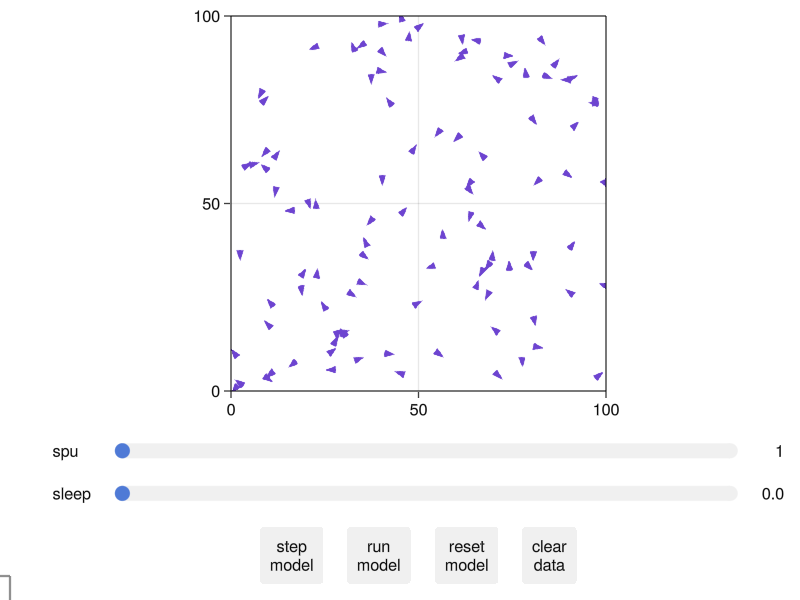

In [17]:
model = initialize_model(
        100,  # bird 수
        1.0,# 1 step당 속력 (방향은 vel에 정의된곳)
        0.05, # 이웃 새들의 평균 위치를 유지하는 중요성
        4.0, # 이웃 새들과 떨어져 있어야 하는 최소 거리
        0.25, # 이웃 새들과의 최소거리를 유지하는 중요성
        0.25, #  이웃 새들의 평균 궤적 일치의 중요성
        5.0, # 새가 볼 수 있는 거리를 나타내며 이웃 새의 반경을 정의
        (100,100),
    )
fig, ax, abmobs= abmplot(model;
agent_step! = agent_step!, model_step! = dummystep,
plotkwargs...)
fig

In [18]:
abmvideo(
    "flocking.mp4", model, agent_step!;
    title="Flocking",
    framerate=20, frames=100,
    plotkwargs...)

<video width="auto" controls autoplay loop source src="flocking.mp4" type="video/mp4"/>

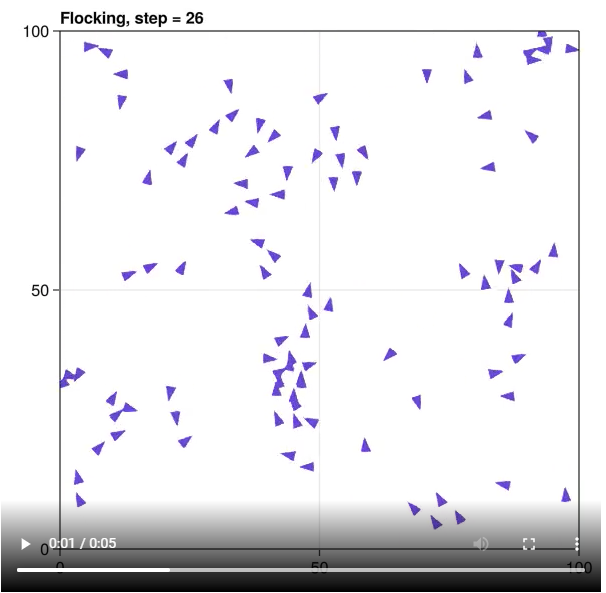